# imports

In [1]:
%matplotlib notebook
from __future__ import division

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from matplotlib.pyplot import plot, ylabel, xlabel, yscale, xscale, legend, subplots, gca, gcf
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from theano import function
import numpy as np
import gzip
import cPickle
from scipy.optimize import minimize
from climin.util import optimizer
from itertools import repeat, cycle, islice, izip, imap
import itertools
import random
inf = float("inf")

gnumpy: failed to import cudamat. Using npmat instead. No GPU will be used.


In [3]:
from breze.learn.data import one_hot
from breze.learn.base import cast_array_to_local_type
from schlichtanders.myfunctools import compose, meanmap, summap, compose_fmap, Average
from schlichtanders import myfunctools
from schlichtanders.mygenerators import eatN, chunk, chunk_list, every, takeN
from schlichtanders.myplot import add_val, add_point
from schlichtanders.mymeta import proxify

In [4]:
from IPython.display import IFrame
import theano_models as tm
import theano_models.deterministic_models as dm
import theano_models.probabilistic_models as pm

In [5]:
import theano
import theano.tensor as T
from theano.printing import debugprint
from theano.tensor.shared_randomstreams import RandomStreams

In [6]:
from sqlalchemy import Column, Integer, Unicode, UnicodeText, String, PickleType, Float
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.declarative import declarative_base

In [7]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [8]:
tm.inputting_references.update(['to_be_randomized'])
tm.inputting_references, tm.outputting_references

({'extra_inputs',
  'flat',
  'inputs',
  'n_data',
  'parameters',
  'parameters_positive',
  'parameters_psumto1',
  'to_be_randomized'},
 {'kl_prior', 'loglikelihood', 'norm_det', 'norm_dets', 'outputs'})

In [9]:
from schlichtanders.myobjects import NestedNamespace

# Simple Posterior

For testing we choose a conjugate likelihood/prior combination such that the resulting posterior form is known in advance.

It seems the only combination with commonly known results is Gauss, considering that we need a distribution which can be expressed as a function of some standard random source, because of stochastic backpropagation.

As the final goal is to have more complex distributions than Gaussians, another distribution might

In [64]:
prior_u = 0
prior_s2 = 0.5

likelihood_s2 = 2

sample = np.random.normal(size=100, scale=4, loc=5)

posterior_s2 = 1 / (1/prior_s2 + len(sample)/likelihood_s2)
posterior_u = (prior_u/prior_s2 + sample.sum()/likelihood_s2) * posterior_s2

In [65]:
posterior_u, posterior_s2

(5.040005019018122, 0.019230769230769232)

In [66]:
likelihood = tm.Merge(pm.Gauss(init_var=likelihood_s2),
                      ignore_references={'parameters_positive'})
likelihood

Merge14 { 'inputs': [], 'outputs': Gauss7.outputs, 'parameters': [mean]}

In [67]:
q = pm.Gauss()
q

Gauss8 { 'inputs': [],
  'outputs': Gauss8.outputs,
  'parameters': [mean],
  'parameters_positive': [var]}

In [68]:
prior = tm.fix_params(pm.Gauss(init_mean=prior_u, init_var=prior_s2))
prior

Gauss9_fixed { 'inputs': [], 'outputs': Gauss9.outputs}

In [69]:
model = tm.variational_bayes(likelihood, 'parameters', q, priors=prior)
model

variational_lower_bound4 { 'inputs': [],
  'kl_prior': variational_lower_bound4.kl_prior,
  'logposterior': variational_lower_bound4.logposterior,
  'logprior': variational_lower_bound4.logprior,
  'n_data': n_data,
  'outputs': Gauss7.outputs,
  'parameters': [mean],
  'parameters_positive': [var]}

In [70]:
_params = tm.prox_reparameterize(model['parameters_positive'], tm.squareplus, tm.squareplus_inv)
flat_parameters = tm.prox_flatten(tm.prox_center(model['parameters'] + _params))
flat_parameters

"mean_centered:var_squareplus_centered"

In [71]:
tm.d3viz(([flat_parameters] + model.logP['inputs'], model.logP['outputs']), 'tmp/model.html')
IFrame('tmp/model.html', width=700, height=500)

In [72]:
tm.reduce_all_identities()

In [73]:
loss = tm.loss_variational(model)
optimizer_kwargs = tm.numericalize(
    loss, flat_parameters,
    batch_mapreduce=summap,
    annealing_combiner=tm.AnnealingCombiner(),
    adapt_init_params=lambda ps: ps + np.random.normal(size=ps.shape, scale=0.01),
)
climin_args = izip(imap(lambda x:(x,), itertools.repeat(sample)), itertools.repeat({}))

In [74]:
next(climin_args)

((array([  6.43272071,   6.07642869,  -1.45772056,   6.36624435,
           7.75425277,   8.18870164,   7.66014235,  -0.66796849,
           8.60540419,  -0.49663594,   6.41297115,  -0.17547284,
           1.35677297,   8.02322198,   3.95721259,   5.75301674,
           0.70356945,   7.60702669,   9.80541203,   5.0153483 ,
           2.92539374,   4.59827294,   4.55117019,  13.62594838,
          12.27824517,   0.97552681,  16.96011346,   6.52500565,
           6.05483924,   1.63418243,   3.90360553,  -2.42273898,
           6.79407635,   5.08775537,   5.08054846,   4.55132996,
          13.46771992,   5.13133731,   7.55697045,   0.3408306 ,
           3.15456715,   2.37031271,   3.92843537,  -2.55057035,
           8.07360326,   0.55734529,   7.68073207,   6.56544655,
           1.03388412,   3.09887297,  -0.35057823,   5.61770333,
          -1.34214903,   8.65303137,  11.95594535,  -1.62083245,
           5.80144903,   6.34940281,   4.82064347,   0.17164096,
           2.02777263,  1

In [75]:
opt = optimizer(
    identifier="adadelta",
#     steprate=1e-6,
    args=climin_args,
    **tm.climin_kwargs(optimizer_kwargs)
)

In [76]:
best_loss = optimizer_kwargs['num_loss'](opt.wrt, sample)
best_params = None
last_best_i = opt.n_iter

<IPython.core.display.Javascript object>


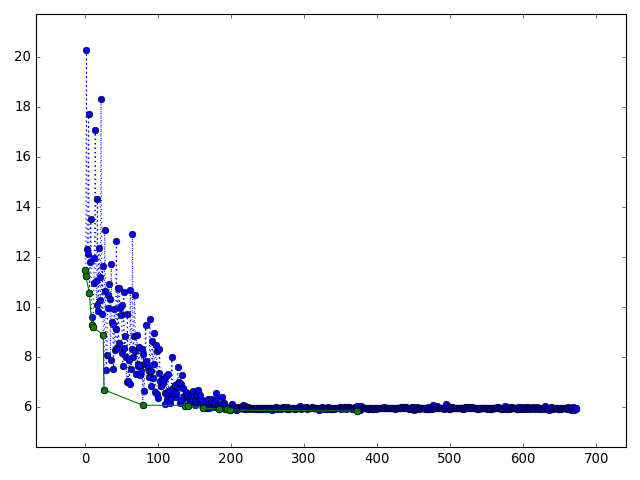

In [77]:
plt.figure()
h = plt.plot(last_best_i, best_loss, 'b:o')[0]
h_best = plt.plot(last_best_i, best_loss, 'g-o')[0]

In [78]:
for info in opt:
    loss = optimizer_kwargs['num_loss'](opt.wrt, sample)
    if opt.n_iter - last_best_i > 300:
        break
    if loss < best_loss:
        last_best_i = opt.n_iter
        best_loss = loss
        best_params = opt.wrt
        add_point(h_best, opt.n_iter, best_loss)
    add_point(h, opt.n_iter, loss)

In [79]:
best_loss

5.8162158910069115

In [80]:
params = q['parameters'] + q['parameters_positive']
f_q_param = theano.function([flat_parameters], params)

In [81]:
zip(map(str, params), f_q_param(best_params))

[('mean_centered', array(4.9365693502952785)),
 ('var_reparam', array(0.05294422399025088))]

We fortunately get roughly the parameters of the posterior. The variance seems overestimated, always, but still fine. Kind of a factor of two.

# Complex Posterior

In [31]:
x = tm.as_tensor_variable([0.5]) #T.vector()
y = x + 0.3 * T.sin(2*np.pi*x)
func = tm.Model(inputs=[x], outputs=y, name="sin")

In [32]:
likelihood = tm.Merge(pm.GaussianNoise(y, init_var=0.001), func, ignore_references={'parameters', 'parameters_positive'})
likelihood

Merge6 { 'inputs': [TensorConstant{(1,) of 0.5}], 'outputs': GaussianNoise.outputs}

In [33]:
sampler = likelihood.function()
data = np.array([sampler([0.5]) for n in range(1000)])

---

In [34]:
prior = tm.fix_params(pm.DiagGauss(1, init_var=[1]))
base_posterior = pm.DiagGauss(1)
transform_posterior = dm.PlanarTransform()
posterior = tm.normalizing_flow(transform_posterior, base_posterior)
model = tm.variational_bayes(likelihood, 'inputs', posterior, priors=prior)

In [35]:
loss = tm.loss_variational(model)
tm.reduce_all_identities()

In [36]:
transform_posterior

PlanarTransform { 'inputs': [DiagGauss2.outputs],
  'norm_det': PlanarTransform.norm_det,
  'outputs': PlanarTransform.outputs,
  'parameters': [b, w, _u]}

In [37]:
transform_posterior.inverse

Inverse_PlanarTransform { 'inputs': [PlanarTransform.outputs],
  'norm_det': Inverse_PlanarTransform.norm_det,
  'outputs': DiagGauss2.outputs,
  'parameters': [b, w, _u]}

In [38]:
base_posterior['outputs']

DiagGauss2.outputs

In [39]:
_params = tm.prox_reparameterize(model['parameters_positive'], tm.squareplus, tm.squareplus_inv)
centred = tm.prox_center(model['parameters'] + _params)
flat = tm.prox_flatten(centred)

In [40]:
tm.d3viz(loss, "tmp/loss.html")
IFrame("tmp/loss.html", width=700, height=700)

In [41]:
optimizer_kwargs = tm.numericalize(loss, flat,
    batch_mapreduce=summap,
    annealing_combiner=tm.AnnealingCombiner(),
    adapt_init_params=lambda ps: ps + np.random.normal(size=ps.shape, scale=0.01),
)
opt = optimizer(
    identifier="adadelta",
    **tm.climin_kwargs(optimizer_kwargs)
)

TODO Continue testing this